In [1]:
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score

from utils.data_augmentation import rotate_keypoints_sequence
from utils.keypoints import read_keypoints, rescale_keypoints, rescale_keypoints_sequence, keypoints_sequence_padding

from model.datasets import SequenceKeypointsDataset
from model.transforms import RotateKeypointsSequence, KeypointsSequencePadding
from model.models import SequenceRecognitionNet

import torch
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Sampler

from torch import nn
import torch.nn.functional as F

In [2]:
JSON_FILES_PATH = [
    './data/labels/sequence/sequence_labelsSep-16-2020_0516.json',
    './data/labels/sequence/sequence_labelsSep-16-2020_1930.json',
    './data/labels/sequence/sequence_labelsSep-18-2020_0447.json',
    './data/labels/sequence/sequence_labelsSep-18-2020_2351.json'
]
JSON_KEYPOINTS_BASE_PATH = './data/keypoints'
RANDOM_STATE = 42

N_EPOCHS = 1000
BATCH_SIZE = 64
LR = 0.00001

LABEL_OCCURENCES_MIN = 10
SEQUENCE_LENGTH_MAX = 50
NUM_CLASSES = 11

# label_map = {
#     'Meet': 0,
#     'Name': 1,
#     'Hearing person': 2,
#     'Good day': 3,
#     'You': 4,
#     'See you around': 5,
#     'Thank you': 6,
#     'Hello': 7,
#     'Bye bye': 8,
#     'Tom': 9,
#     'Woman': 10,
#     'Nice': 11,
#     'Man': 12,
#     'I': 13,
#     'My': 14
# } 

label_map = {
    'Meet': 0,
    'Name': 1,
    'Good day': 2,
    'See you around': 3,
    'Thank you': 4,
    'Hello': 5,
    'Bye bye': 6,
    'Tom': 7,
    'Nice': 8,
    'You': 9,
    'My': 10
} 

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Stack label files
labels_json = []

for label_file in JSON_FILES_PATH:
    with open(label_file, 'r') as f:
        for row in f.readlines():
            labels_json.append(json.loads(row))

            
# Fix labels
            
# Convert into DataFrame
df = pd.concat(
    [pd.DataFrame(item) for item in labels_json],
    axis=0
).drop(columns=['id'])

# Drop ignore labels
df = df[~df.label.isin(['ignore', '<random movements>', 'My name'])]

# Drop low freq classes
labels_freq = df.label.value_counts()
low_freq_labels = labels_freq[(labels_freq < LABEL_OCCURENCES_MIN)].index.tolist()
df = df[~(df.label.isin(low_freq_labels))]

df = df[df.label.isin(list(label_map.keys()))]

# Get label ID
df['label_id'] = df.label.map(label_map)

df.head()

,video_path,image_path,keypoints_path,label,label_id
0,./data/rendered_video/internal_resource_fps10/...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Hello,5
1,./data/rendered_video/internal_resource_fps10/...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Hello,5
2,./data/rendered_video/internal_resource_fps10/...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Hello,5
3,./data/rendered_video/internal_resource_fps10/...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Hello,5
4,./data/rendered_video/internal_resource_fps10/...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Hello,5


In [4]:
df.shape

(863, 5)

In [5]:
df['length'] = df.image_path.apply(lambda x: len(x))
df.sort_values(by='length')

,video_path,image_path,keypoints_path,label,label_id,length
87,./data/rendered_video/internal_resource_2334_f...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,My,10,15
17,./data/rendered_video/internal_resource_2337_f...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,My,10,15
104,./data/rendered_video/internal_resource_2334_f...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,My,10,16
30,./data/rendered_video/internal_resource_fps10/...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Name,1,16
101,./data/rendered_video/internal_resource_2334_f...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,My,10,16
...,...,...,...,...,...,...
240,./data/rendered_video/internal_resource_2337_f...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Meet,0,47
239,./data/rendered_video/internal_resource_2337_f...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Meet,0,47
237,./data/rendered_video/internal_resource_2337_f...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Meet,0,48
66,./data/rendered_video/internal_resource_2334_f...,[/home/tom/Desktop/projects/sign-language/data...,[/home/tom/Desktop/projects/sign-language/data...,Good day,2,48


In [6]:
print(df.label.value_counts())
print(df.label_id.value_counts())

You               109
My                102
Name               88
Meet               87
Nice               79
Tom                78
Hello              74
Good day           72
Thank you          65
See you around     65
Bye bye            44
Name: label, dtype: int64
9     109
10    102
1      88
0      87
8      79
7      78
5      74
2      72
4      65
3      65
6      44
Name: label_id, dtype: int64


In [7]:
def get_weights(df_train):
    class_sample_count = np.array([len(np.where(df_train.label_id==t)[0]) for t in np.unique(df_train.label_id)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in df_train.label_id])

    return torch.from_numpy(samples_weight)

In [8]:
# Train test split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

# Create Transformer
keypoints_sequence_transform_train = transforms.Compose([
    RotateKeypointsSequence(-30, 30),
    KeypointsSequencePadding(SEQUENCE_LENGTH_MAX)
])
keypoints_sequence_transform_test = transforms.Compose([
    KeypointsSequencePadding(SEQUENCE_LENGTH_MAX)
])

# Initialize Datasets
ds_train = SequenceKeypointsDataset(df_train, keypoints_sequence_transform_train)
ds_test = SequenceKeypointsDataset(df_test, keypoints_sequence_transform_test)

# Initialize Sampler
sampler = torch.utils.data.WeightedRandomSampler(get_weights(df_train), df_train.shape[0])

# Initialize DataLoader
train_dl = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, sampler=sampler)
test_dl = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE)

# Model params
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = SequenceRecognitionNet(NUM_CLASSES).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

In [9]:
ds_train[0][1]

3

In [10]:
df_train.label.value_counts()

You               87
My                83
Name              70
Meet              68
Tom               66
Nice              65
Hello             59
See you around    56
Thank you         54
Good day          51
Bye bye           31
Name: label, dtype: int64

In [11]:
df_test.label.value_counts()

You               22
Good day          21
My                19
Meet              19
Name              18
Hello             15
Nice              14
Bye bye           13
Tom               12
Thank you         11
See you around     9
Name: label, dtype: int64

In [12]:
@torch.no_grad()
def evaluate_model(model, data_loader, print_info=False):
    
    collect_results = []
    collect_targets = []

    for batch in data_loader:
        X, y = batch
        X = X.float().to(DEVICE)
        y = y.float().to(DEVICE).detach().cpu().numpy()

        pred = model(X)
        pred = F.softmax(pred, dim=0)
        collect_results.append(pred.detach().cpu().numpy())
        collect_targets.append(y)

    preds_proba = np.concatenate(collect_results)
    preds = preds_proba.argmax(axis=1)
    targets = np.concatenate(collect_targets)

    ll = log_loss(targets, preds_proba)
    acc = accuracy_score(targets, preds)

    
    if print_info:
        print("test log-loss: {}".format(ll))
        print("overall accuracy:  {}".format(acc))

    return ll, acc

In [13]:
metrics = []
metrics_names = ['loss_train','loss_test','acc_train','acc_test']
losses = []

net.to(DEVICE)

for epoch in range(N_EPOCHS):
    print(f'EPOCH={epoch + 1}')
    for X, y in train_dl:
        X = X.float().to(DEVICE)
        y = y.long().to(DEVICE)
        optimizer.zero_grad()
        
        y_pred = net(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().cpu().numpy())
        
    train_ll, train_acc = evaluate_model(net, train_dl)
    test_ll, test_acc = evaluate_model(net, test_dl)
    
    
    print(f'train: loss={train_ll} acc={train_acc}')
    print(f'test: loss={test_ll} acc={test_acc}')
          
    metrics.append([train_ll, test_ll, train_acc, test_acc])

EPOCH=1
train: loss=2.3889071910277657 acc=0.6710144927536232
test: loss=2.388826370584792 acc=0.6855072463768116
EPOCH=2
train: loss=2.379809872309367 acc=0.7275362318840579
test: loss=2.379878034107927 acc=0.7463768115942029
EPOCH=3
train: loss=2.3679001783979112 acc=0.7347826086956522
test: loss=2.3685322937758073 acc=0.7478260869565218
EPOCH=4
train: loss=2.3530624659165094 acc=0.7855072463768116
test: loss=2.3548875338789346 acc=0.7681159420289855
EPOCH=5
train: loss=2.335299032667409 acc=0.7652173913043478
test: loss=2.3361080836558688 acc=0.7768115942028986
EPOCH=6
train: loss=2.308761332000511 acc=0.7579710144927536
test: loss=2.3109791707301484 acc=0.7623188405797101
EPOCH=7
train: loss=2.2711047044698742 acc=0.8057971014492754
test: loss=2.2772587783094767 acc=0.7753623188405797
EPOCH=8
train: loss=2.23479770352875 acc=0.7608695652173914
test: loss=2.23500943771307 acc=0.7855072463768116
EPOCH=9
train: loss=2.1776196763135385 acc=0.7913043478260869
test: loss=2.18643138754195

<AxesSubplot:>

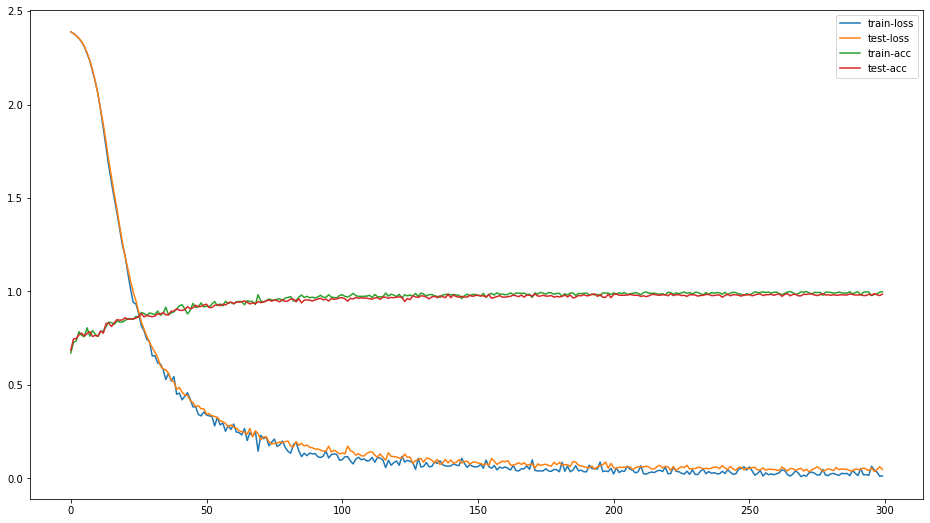

In [14]:
%matplotlib inline
pd.DataFrame(metrics, columns=['train-loss','test-loss','train-acc','test-acc']).plot(subplots=False, figsize=(16,9))

In [15]:
torch.save(net.state_dict(), './model/sequence_classifier.pt')

# m_state_dict = torch.load('mymodule.pt')
# new_m = MyModule()
# new_m.load_state_dict(m_state_dict)